# **BAG OF VISUAL WORDS**

## Introduction to **BoVW**

The Bag-of-Visual-Words (BoVW) is a method for image classification that is commonly used in computer vision and image processing. The basic idea behind BoVW is to represent an image as a histogram of visual words. A visual word is a group of similar feature descriptors of an image, such as a SIFT descriptor. The histogram represents the frequency of occurrence of each visual word in the image.

The BoVW process consists of several steps. First, a set of local feature descriptors, such as SIFT, are extracted from each image. These descriptors are then quantized into visual words using a clustering algorithm, we used k-means, even though we also checked how it works with Gaussian Mixture Model but it was very inefficient, computationally speaking. The resulting visual words were then used to create a histogram of visual words for the image. This histogram represents the image and can be used for image classification.

In our project, we used the BoVW method to classify images into one of the 10 classes: `['person', 'cat', 'bird', 'horse', 'aeroplane', 'bicycle', 'sofa', 'train', 'chair', 'bottle']`.

 The dataset that we used to train and test our classifier consisted of images of these classes. So we used a combination of feature extraction, quantization, and classification techniques to create our final classifier.
BoVW is a powerful and widely used method for image classification.


## Necessary Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#import needed libraries for the project
import cv2
from google.colab.patches import cv2_imshow
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import xml.etree.ElementTree as ET
from sklearn.cluster import KMeans
from scipy.cluster.vq import kmeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.stats import chisquare
from scipy.stats import ks_2samp
import joblib
from scipy.stats import chisquare
from numpy.linalg import norm
from collections import Counter
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## Loading and Scrubbing the data

First we define the classes/labels we are going to use. These are the objects that each image can contain:

In [ ]:
labels = ['person', 'cat', 'bird', 'horse', 'aeroplane', 'bicycle', 'sofa', 'train', 'chair', 'bottle']

then we import the .xml files from the Annotations folder to extract the images from the JPEGImages that 

In [ ]:
# Create an empty dictionary to store the image file paths and labels:
data = {}

# Create a dictionary to store the number of images of each class:
counts = {label: 0 for label in labels}

# Define the paths to the Annotations and JPEGImages Folders:
annotations_path = Path('/content/drive/MyDrive/data_and_labels/Annotations')
jpegimages_path = Path('/content/drive/MyDrive/data_and_labels/JPEGImages')

# Iterate through the XML files in the Annotations folder:
for xml_file in annotations_path.glob('*.xml'):

    # Get the image file name (without the .xml extension):
    image_name = xml_file.stem

    # Get the image file path in the JPEGImages folder:
    image_path = jpegimages_path / (image_name + '.jpg')

    # Parse the XML file:
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Get the object label(s) for the image:
    image_labels = []

    for obj in root.iter('object'):
        label = obj.find('name').text
        if label in labels:
            image_labels.append(label)

    # If the image has exactly one object label, add it to the data dictionary:
    if len(image_labels) == 1:
        counts[image_labels[0]] += 1 
        data[image_path] = image_labels

least = min(counts.values())

# Create a new empty dictionary to store the normalized data. Normalized data in this case means that each class has the same number of images:
data_normalized = {}

# Create a dictionary to keep track of the number of images added for each class in the whole dataset:
class_counts = {label: 0 for label in labels}

# Iterate through the items in the data dictionary:
for key, value in data.items():
    # Check if the number of images added for the current class is less than the limit. The limit is equal to the number of images of the class that has fewer images:
    if class_counts[value[0]] < least:
        # Add the item to the data_normalized dictionary:
        data_normalized[key] = value
        class_counts[value[0]] += 1

    # Check if the total number of images added is equal to the limit * the number of classes:
    if sum(class_counts.values()) == least*len(labels):
        # If true, break the loop.
        break

In [ ]:
# Print the data to check if the images are being added to the dictionary as expected
data_normalized  #here each key of the dictionary is a path to open an image and the value is the label of that image

{PosixPath('/content/drive/MyDrive/data_and_labels/JPEGImages/2008_000510.jpg'): ['person'],
 PosixPath('/content/drive/MyDrive/data_and_labels/JPEGImages/2008_000512.jpg'): ['bird'],
 PosixPath('/content/drive/MyDrive/data_and_labels/JPEGImages/2008_000496.jpg'): ['person'],
 PosixPath('/content/drive/MyDrive/data_and_labels/JPEGImages/2008_000455.jpg'): ['person'],
 PosixPath('/content/drive/MyDrive/data_and_labels/JPEGImages/2008_000472.jpg'): ['bird'],
 PosixPath('/content/drive/MyDrive/data_and_labels/JPEGImages/2008_000436.jpg'): ['person'],
 PosixPath('/content/drive/MyDrive/data_and_labels/JPEGImages/2008_000443.jpg'): ['person'],
 PosixPath('/content/drive/MyDrive/data_and_labels/JPEGImages/2008_000428.jpg'): ['horse'],
 PosixPath('/content/drive/MyDrive/data_and_labels/JPEGImages/2008_000470.jpg'): ['train'],
 PosixPath('/content/drive/MyDrive/data_and_labels/JPEGImages/2008_000426.jpg'): ['person'],
 PosixPath('/content/drive/MyDrive/data_and_labels/JPEGImages/2008_000445.jp

These are the number of images per class in the whole dataset.

In [ ]:
counts

{'person': 5088,
 'cat': 803,
 'bird': 584,
 'horse': 163,
 'aeroplane': 494,
 'bicycle': 196,
 'sofa': 170,
 'train': 347,
 'chair': 238,
 'bottle': 168}

 Note that the images that we use are not all of them, actually we use 1630 images
to avoid the bias, as the class with less images has 163 images(horse) and 163 x 10 classes = 1630 images

Let's print the class_counts to check if the images are being counted and stored as expected. 

In [ ]:
print(class_counts)
print(sum(class_counts.values()))

{'person': 163, 'cat': 163, 'bird': 163, 'horse': 163, 'aeroplane': 163, 'bicycle': 163, 'sofa': 163, 'train': 163, 'chair': 163, 'bottle': 163}
1630


Now we need to split the data into train and test set. First, we convert the data normalized in tuples so that we can split the data properly using sklearn module. The train will have 80% of the data and test will have 20%

In [ ]:
# Convert the data dictionary to a list of tuples
data_list = [(k, v) for k, v in data_normalized.items()]

# Use the train_test_split function on the list of tuples
train_data, test_data = train_test_split(data_list, test_size=0.2)

Let's take a look of the data:

In [ ]:
print("Total number of images in train data:", len(train_data),'\n')
train_data

Total number of images in train data: 1304 



[(PosixPath('/content/drive/MyDrive/data_and_labels/JPEGImages/2008_005719.jpg'),
  ['aeroplane']),
 (PosixPath('/content/drive/MyDrive/data_and_labels/JPEGImages/2008_007760.jpg'),
  ['train']),
 (PosixPath('/content/drive/MyDrive/data_and_labels/JPEGImages/2009_002684.jpg'),
  ['horse']),
 (PosixPath('/content/drive/MyDrive/data_and_labels/JPEGImages/2008_004730.jpg'),
  ['bird']),
 (PosixPath('/content/drive/MyDrive/data_and_labels/JPEGImages/2009_000347.jpg'),
  ['train']),
 (PosixPath('/content/drive/MyDrive/data_and_labels/JPEGImages/2010_000721.jpg'),
  ['bottle']),
 (PosixPath('/content/drive/MyDrive/data_and_labels/JPEGImages/2010_004288.jpg'),
  ['bottle']),
 (PosixPath('/content/drive/MyDrive/data_and_labels/JPEGImages/2007_004009.jpg'),
  ['aeroplane']),
 (PosixPath('/content/drive/MyDrive/data_and_labels/JPEGImages/2009_002853.jpg'),
  ['bicycle']),
 (PosixPath('/content/drive/MyDrive/data_and_labels/JPEGImages/2008_001078.jpg'),
  ['cat']),
 (PosixPath('/content/drive/MyD

In [ ]:
print("Total number of images in test data:", len(test_data),'\n')
test_data

Total number of images in test data: 326 



[(PosixPath('/content/drive/MyDrive/data_and_labels/JPEGImages/2010_004477.jpg'),
  ['horse']),
 (PosixPath('/content/drive/MyDrive/data_and_labels/JPEGImages/2008_005455.jpg'),
  ['aeroplane']),
 (PosixPath('/content/drive/MyDrive/data_and_labels/JPEGImages/2009_001806.jpg'),
  ['chair']),
 (PosixPath('/content/drive/MyDrive/data_and_labels/JPEGImages/2009_000928.jpg'),
  ['chair']),
 (PosixPath('/content/drive/MyDrive/data_and_labels/JPEGImages/2007_007698.jpg'),
  ['aeroplane']),
 (PosixPath('/content/drive/MyDrive/data_and_labels/JPEGImages/2009_004797.jpg'),
  ['bicycle']),
 (PosixPath('/content/drive/MyDrive/data_and_labels/JPEGImages/2010_004765.jpg'),
  ['sofa']),
 (PosixPath('/content/drive/MyDrive/data_and_labels/JPEGImages/2008_000581.jpg'),
  ['cat']),
 (PosixPath('/content/drive/MyDrive/data_and_labels/JPEGImages/2007_001149.jpg'),
  ['sofa']),
 (PosixPath('/content/drive/MyDrive/data_and_labels/JPEGImages/2007_004143.jpg'),
  ['bird']),
 (PosixPath('/content/drive/MyDrive

Loading the images of the train and test set with openCV function. The images are stored in a dictionary were the keys are 'image_n' where n is the number of the image and the content of each key is a list with the image (the array read with cv2) and the label of that image.

In [ ]:
#Image classes dictionary (each of the keys in the dictionary will include all the images that have that given label)
train_images = {}

#we traverse image paths and labels in the train data
for i, (image_path, image_labels) in enumerate(train_data):
    # Convert the image path to a string as it is a PosixPath object
    image_path = str(image_path)

    # Read the image
    image = cv2.imread(image_path)
    #update the dictionary, append the images to the empty list of images for each value
    for label in image_labels:
        train_images['image_' + str(i)] = [image, label]

In [ ]:
#Image classes dictionary (each of the keys in the dictionary will include all the images that have that given label)
test_images = {}

#we traverse image paths and labels in the test data:
for i, (image_path, image_labels) in enumerate(test_data):
    # Convert the image path to a string as it is a PosixPath object
    image_path = str(image_path)

    # Read the image
    image = cv2.imread(image_path)
    #update the dictionary, append the images to the empty list of images for each value
    for label in image_labels:
        test_images['image_' + str(i)] = [image, label]

Let's visualize how an image looks like for our computer

In [ ]:
#The content of the train_images dictionary for the first image:
print(train_images['image_0'])


[array([[[197, 182, 186],
        [196, 181, 185],
        [196, 182, 184],
        ...,
        [199, 178, 180],
        [199, 179, 178],
        [200, 179, 178]],

       [[196, 181, 185],
        [197, 180, 184],
        [197, 180, 183],
        ...,
        [197, 176, 179],
        [198, 177, 180],
        [198, 177, 180]],

       [[197, 180, 184],
        [197, 180, 184],
        [196, 179, 183],
        ...,
        [198, 178, 177],
        [198, 178, 177],
        [199, 180, 177]],

       ...,

       [[105, 100, 101],
        [103,  96, 109],
        [103,  97, 108],
        ...,
        [ 95,  87,  80],
        [ 95,  83,  79],
        [ 96,  83,  81]],

       [[ 95,  98,  82],
        [102, 100, 100],
        [103,  99,  98],
        ...,
        [ 84,  63,  55],
        [ 86,  63,  55],
        [ 88,  64,  58]],

       [[ 93,  89,  78],
        [100,  95,  86],
        [ 95,  93,  75],
        ...,
        [ 92,  56,  56],
        [ 93,  57,  57],
        [ 92,  58,  59]

## Calculate the descriptors

The first thing we need for the Bag of Words is to extract the descriptors of the images. For this task we are going to use SIFT to calculate the descriptors and they will by added to the list of each image, so the list now has three elements: image (array), label and descriptors (array of shape: n x 128).

We compute the descriptors for each image in the training set

In [ ]:
for i, image in enumerate(train_images.values()):
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image[0], cv2.COLOR_BGR2GRAY)

    # Create a SIFT object
    sift = cv2.xfeatures2d.SIFT_create(nfeatures = 300)

    # Compute SIFT descriptors for the image
    kp, des = sift.detectAndCompute(gray_image, None)
    
    #add the descriptors to the list of information of each image
    train_images['image_'+ str(i)].append(des)

We compute the descriptors for each image in the test set

In [ ]:
for i, image in enumerate(test_images.values()):
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image[0], cv2.COLOR_BGR2GRAY)

    # Create a SIFT object
    sift = cv2.xfeatures2d.SIFT_create(nfeatures=300)

    # Compute SIFT descriptors for the image
    kp, des = sift.detectAndCompute(gray_image, None)
    
    #add the descriptors to the list of information of each image
    test_images['image_'+ str(i)].append(des)

Now each list of each image has three elements: Image, label and Descriptors

In [ ]:

train_images['image_0']

[array([[[197, 182, 186],
         [196, 181, 185],
         [196, 182, 184],
         ...,
         [199, 178, 180],
         [199, 179, 178],
         [200, 179, 178]],
 
        [[196, 181, 185],
         [197, 180, 184],
         [197, 180, 183],
         ...,
         [197, 176, 179],
         [198, 177, 180],
         [198, 177, 180]],
 
        [[197, 180, 184],
         [197, 180, 184],
         [196, 179, 183],
         ...,
         [198, 178, 177],
         [198, 178, 177],
         [199, 180, 177]],
 
        ...,
 
        [[105, 100, 101],
         [103,  96, 109],
         [103,  97, 108],
         ...,
         [ 95,  87,  80],
         [ 95,  83,  79],
         [ 96,  83,  81]],
 
        [[ 95,  98,  82],
         [102, 100, 100],
         [103,  99,  98],
         ...,
         [ 84,  63,  55],
         [ 86,  63,  55],
         [ 88,  64,  58]],
 
        [[ 93,  89,  78],
         [100,  95,  86],
         [ 95,  93,  75],
         ...,
         [ 92,  56,  56],
  

this is the shape of the array of descriptors of the first train image:

In [ ]:

train_images['image_0'][2].shape

(300, 128)

We group all the descriptors per label only for the training data in the following way:

In [ ]:
#Dictionary to store the descriptors per label
train_descriptors = {}

#Initialization of the dictionary with empty lists
for label in labels:
    train_descriptors[label] = []

for image in train_images.values():
    #we want to append the descriptors of each of the images of each class to its
    #correspondent list
    train_descriptors[image[1]].append(image[2])

for label in train_descriptors:
    #with np.concatenate wi will join all the descriptors for a given class in
    #the same value of the dictionary
    train_descriptors[label] = np.concatenate(train_descriptors[label])

## Calculate The Vocabulary

Since we need all the descriptors together to make the Vocabulary we join all of them in a single array:

In [ ]:
#We add all the descriptors in a list so we have a list of groups of descriptors per class
all_descriptors = []
for descriptors in train_descriptors.values():
    all_descriptors.append(descriptors)

In [ ]:
#then we concatenate all elements to obtain a single array with all the descriptors in the train set.
all_descriptors = np.concatenate(all_descriptors)
all_descriptors

array([[  0.,   1., 121., ...,   1.,  12.,  43.],
       [ 27.,   0.,   0., ...,   0.,   0.,   1.],
       [  2.,   0.,   0., ...,   5.,  23.,  26.],
       ...,
       [  1.,   5.,  29., ...,   8.,   1.,   0.],
       [ 58.,  24.,   9., ...,  20.,   6.,   6.],
       [ 14., 120., 120., ...,  21.,  36.,   8.]], dtype=float32)

The following is the shape of all the descriptors in an array. First value is the number of descriptors and the second one is the dimensions of each descriptor


In [ ]:

all_descriptors.shape

(359172, 128)

Let's get the number of total descriptors, which will be used for Normalization

In [ ]:
n_total_descriptors = all_descriptors.shape[0]

Now we compute the Big Vocabulary using MiniBatchKMeans, an alternative way to use kmeans but using faster computations so we can test the algorithm many time without waiting too much at each try and avoiding RAM crashes in colab.

In [ ]:
from sklearn.cluster import MiniBatchKMeans

# Define the number of clusters/words (vocabulary size)
n_clusters = 10000

# Create a MiniBatchKMeans model
mbkmeans = MiniBatchKMeans(n_clusters=n_clusters)

# Fit the model to the descriptors
mbkmeans.fit(all_descriptors)

MiniBatchKMeans(n_clusters=10000)

For visualizaton, we plot the histogram of all words in the training data

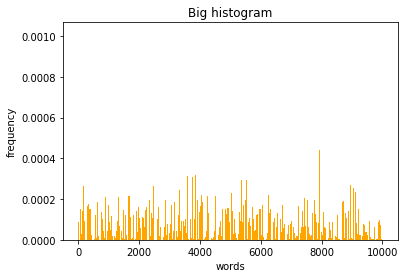

In [ ]:
# Assign each descriptor to its closest cluster
labels = mbkmeans.predict(all_descriptors)

# Create an empty histogram with n_clusters bins
hist = np.zeros(n_clusters)

# Count the number of descriptors in each cluster
for label in labels:
    hist[label] += 1

# Normalize the histogram by dividing all bin values by the sum of all bin values
hist_normalized = hist / n_total_descriptors

# Plot the histogram
plt.bar(np.arange(n_clusters), hist_normalized, color = 'orange')
plt.ylabel('frequency')
plt.xlabel('words')
plt.title('Big histogram')
plt.show()


the sum of the frequencies, as it is normalized, should add up to 1

## Generate the Histograms of each class

Here we generate the histograms that we need for each class that are the histograms that we use to compare the histogram of words of the test images to know the class they belong to.

In [ ]:
#dictionary to store the histogram of each class
class_histograms = {}

#number of total descriptors in the training set. Wee need this number to normalize the histograms
n_total_descriptors = all_descriptors.shape[0]  #[0] is the index to access the rows of the array that says how many descriptors it contains

# Iterate over each class
for label in train_descriptors:

    #predict the words that each class has
    predicted_words = mbkmeans.predict(train_descriptors[label])

    #making the histogram with the words
    histogram = np.bincount(predicted_words, minlength=n_clusters)

    #normalization of the histogram
    norm_histogram = histogram / n_total_descriptors

    #save the histogram normalized of the class 'label'
    class_histograms[label] = norm_histogram

In [ ]:
train_descriptors['bicycle'][0].shape

(128,)

In [ ]:
class_histograms

{'person': array([2.22734512e-05, 1.39209070e-05, 2.22734512e-05, ...,
        0.00000000e+00, 1.67050884e-05, 0.00000000e+00]),
 'cat': array([1.39209070e-05, 2.78418139e-06, 2.22734512e-05, ...,
        2.78418139e-06, 2.50576326e-05, 5.56836279e-06]),
 'bird': array([8.35254418e-06, 8.35254418e-06, 1.67050884e-05, ...,
        5.56836279e-06, 8.35254418e-06, 5.56836279e-06]),
 'horse': array([2.50576326e-05, 8.35254418e-06, 2.78418139e-05, ...,
        2.78418139e-06, 1.39209070e-05, 5.56836279e-06]),
 'aeroplane': array([1.11367256e-05, 2.78418139e-06, 2.78418139e-05, ...,
        2.78418139e-06, 5.56836279e-06, 2.78418139e-06]),
 'bicycle': array([1.94892698e-05, 8.35254418e-06, 4.45469023e-05, ...,
        2.78418139e-06, 0.00000000e+00, 2.78418139e-06]),
 'sofa': array([8.35254418e-06, 8.35254418e-06, 2.50576326e-05, ...,
        0.00000000e+00, 2.50576326e-05, 2.78418139e-06]),
 'train': array([1.39209070e-05, 1.11367256e-05, 1.94892698e-05, ...,
        2.78418139e-06, 8.35254

Visualization of the histogram of each class:

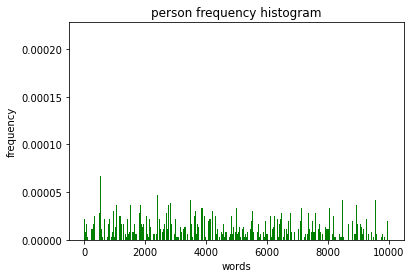

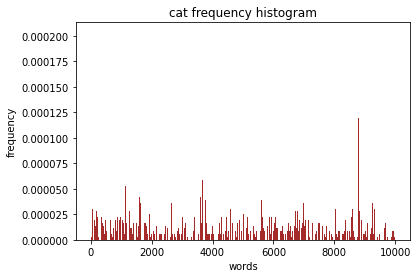

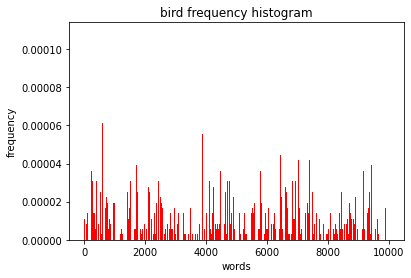

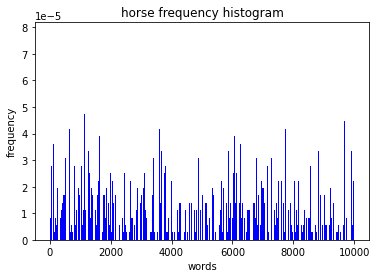

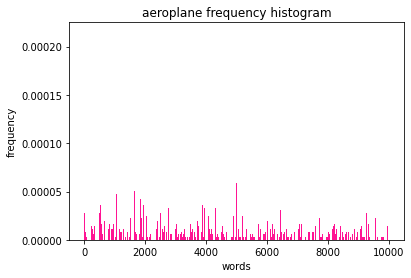

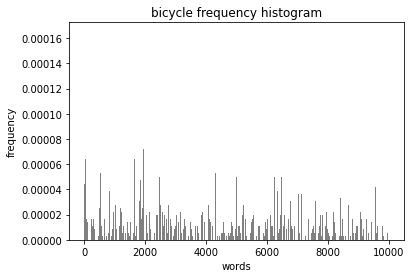

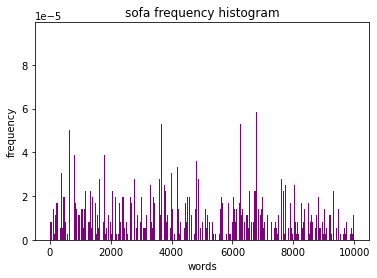

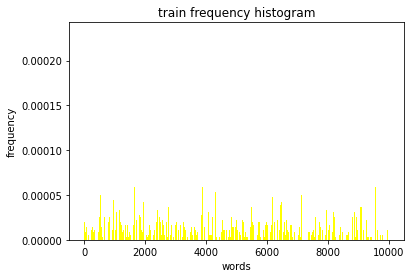

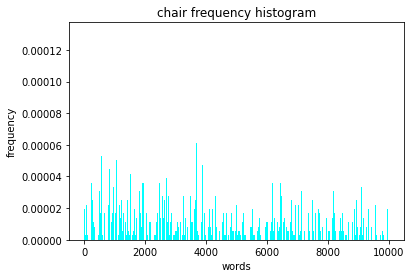

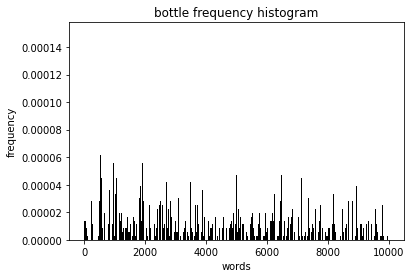

In [ ]:
colors = ['green','brown', 'red', 'blue', 'deeppink','gray', 'purple', 'yellow', 'cyan', 'black']
for (label,hist),color in zip(class_histograms.items(), colors):
    plt.bar(np.arange(len(hist)), hist, color = color)
    plt.title(str(label)+' frequency histogram')
    plt.ylabel('frequency')
    plt.xlabel('words')
    #plt.ylim(top=0.000075)
    plt.show()

the sum of the frequencies, as it is normalized, should add up to 1

## Testing Classification

The method to classify the images is the following:

1.   Use the descriptors of each image to predict the words of each image
2.   take this vocabulary of the image to calculate the histogram of its words
3.   Calculate which histogram of the classes looks more similar to the histgram of the test image. This comparison can be made using euclidean distance, cosine similarity, manhattan_distance, histogram intersection and many other metrics.
4.   The class of the histograms that has the best score after comparison with the histogram of the test image, according to the metric used, is the class of the test image.







First we compute the histograms of each test image and we normalize them in order to compare them 

In [ ]:
# Create an empty list to store the histograms of the test images
test_histograms = []

# Iterate through the test images
for image in test_images.values():
    # Assign each descriptor to its closest cluster
    descriptors = image[2] #the third position correspond to the descriptors of the image
    #projecting the descriptors of the image in the vocabulary to generate its words
    words = mbkmeans.predict(descriptors)
    # Create an empty histogram with n_clusters bins
    hist = np.zeros(n_clusters)
    # Count the number of descriptors in each cluster
    for word in words:
        hist[word] += 1
    # Normalize the histogram by dividing all bin values by the sum of all bin values
    hist_normalized = hist / len(descriptors)
    # Append the histogram to the list
    test_histograms.append(hist_normalized)

This is how histograms for each test images looks like:

In [ ]:
test_histograms

[array([0.        , 0.        , 0.00333333, ..., 0.        , 0.        ,
        0.        ]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0.00333333, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0.00333333, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0

The following are several histogram comparison methods that we´ll try and test

In [ ]:
def euclidean_distance(vec1, vec2):
    return np.linalg.norm(vec1 - vec2)

def manhattan_distance(vec1, vec2):
    return np.sum(np.abs(vec1 - vec2))

def cosine_similarity(A,B):
    return np.dot(A,B)/(norm(A)*norm(B))

def jaccard_similarity(vec1, vec2):
    vec1 = set(np.nonzero(vec1)[0])
    vec2 = set(np.nonzero(vec2)[0])
    return len(vec1.intersection(vec2)) / len(vec1.union(vec2))

def pearson_correlation(vec1, vec2):
    return np.corrcoef(vec1, vec2)[0, 1]

We will store this methods in a dictionary

In [ ]:
comparison_methods = {"Cosine Similarity": cosine_similarity, "Euclidean Distance": euclidean_distance, "Manhattan Distance": manhattan_distance, "Pearson Correlation": pearson_correlation, "Jaccard Similarity": jaccard_similarity}
#select one of the above
selected_method = "Cosine Similarity"
comparison_method = comparison_methods[selected_method]

So let's predict the labels using the selected method

In [ ]:

# Create an empty list to store the predicted labels of the test images
predicted_labels = []

# Iterate through the test images
for i, (image_path, label) in enumerate(test_data):
    # Initialize the best_score and best_label variables to high values
    best_score = -float("inf")
    best_label = None
    # Iterate through the classes
    for class_label, hist in class_histograms.items():
        # Compute the Bhattacharyya distance between the histograms
        score = comparison_method(test_histograms[i],hist)
        # If the score is higher than the best_score
        if score >= best_score:
            # Update the best_score and best_label variables
            best_score = score
            best_label = class_label
    # Append the predicted label to the list
    predicted_labels.append(best_label)

This are the predicted labels

In [ ]:
predicted_labels

['bicycle',
 'aeroplane',
 'person',
 'bird',
 'aeroplane',
 'bicycle',
 'bottle',
 'cat',
 'bicycle',
 'horse',
 'bottle',
 'bicycle',
 'horse',
 'bird',
 'chair',
 'aeroplane',
 'bicycle',
 'sofa',
 'aeroplane',
 'person',
 'cat',
 'chair',
 'aeroplane',
 'bird',
 'train',
 'person',
 'horse',
 'sofa',
 'cat',
 'cat',
 'horse',
 'sofa',
 'person',
 'chair',
 'horse',
 'horse',
 'sofa',
 'cat',
 'bicycle',
 'bottle',
 'train',
 'train',
 'horse',
 'chair',
 'bicycle',
 'bottle',
 'bicycle',
 'horse',
 'person',
 'chair',
 'sofa',
 'train',
 'horse',
 'train',
 'train',
 'sofa',
 'train',
 'person',
 'horse',
 'train',
 'bicycle',
 'train',
 'bird',
 'chair',
 'bicycle',
 'cat',
 'horse',
 'bird',
 'person',
 'bird',
 'bird',
 'train',
 'chair',
 'horse',
 'horse',
 'cat',
 'person',
 'chair',
 'horse',
 'bicycle',
 'chair',
 'bicycle',
 'cat',
 'horse',
 'chair',
 'chair',
 'train',
 'chair',
 'bird',
 'aeroplane',
 'chair',
 'cat',
 'train',
 'horse',
 'horse',
 'bicycle',
 'horse',


Let's see how many images of each class have we predicted

In [ ]:

print(Counter(predicted_labels).keys()) # equals to list(set(words))
print(Counter(predicted_labels).values()) # counts the elements' frequency

dict_keys(['bicycle', 'aeroplane', 'person', 'bird', 'bottle', 'cat', 'horse', 'chair', 'sofa', 'train'])
dict_values([44, 23, 20, 27, 24, 29, 53, 38, 27, 41])


Now we will see the true labels against predicted ones, for checking performance aftewards

In [ ]:
true_labels = []
correct_count = 0
for label in test_images.values():
    true_labels.append(label[1])
for i in range(len(predicted_labels)):
    print("Predicted Labels:", predicted_labels[i])
    print("True Labels:     ", true_labels[i])
    print("")
    if true_labels[i] == predicted_labels[i]:
        correct_count += 1
print('total correct assignations',correct_count)

Predicted Labels: bicycle
True Labels:      horse

Predicted Labels: aeroplane
True Labels:      aeroplane

Predicted Labels: person
True Labels:      chair

Predicted Labels: bird
True Labels:      chair

Predicted Labels: aeroplane
True Labels:      aeroplane

Predicted Labels: bicycle
True Labels:      bicycle

Predicted Labels: bottle
True Labels:      sofa

Predicted Labels: cat
True Labels:      cat

Predicted Labels: bicycle
True Labels:      sofa

Predicted Labels: horse
True Labels:      bird

Predicted Labels: bottle
True Labels:      bottle

Predicted Labels: bicycle
True Labels:      bicycle

Predicted Labels: horse
True Labels:      bottle

Predicted Labels: bird
True Labels:      horse

Predicted Labels: chair
True Labels:      bird

Predicted Labels: aeroplane
True Labels:      train

Predicted Labels: bicycle
True Labels:      bicycle

Predicted Labels: sofa
True Labels:      train

Predicted Labels: aeroplane
True Labels:      aeroplane

Predicted Labels: person
True L

Now let's see how many images were really of each class

In [ ]:
print(Counter(true_labels).keys()) # equals to list(set(words))
print(Counter(true_labels).values()) # counts the elements' frequency

dict_keys(['horse', 'aeroplane', 'chair', 'bicycle', 'sofa', 'cat', 'bird', 'bottle', 'train', 'person'])
dict_values([33, 27, 36, 36, 39, 29, 38, 29, 30, 29])


Now we will show the report, here we will be able to see how our BoVW worked

In [ ]:
confusion_mat = confusion_matrix(true_labels, predicted_labels)
print(confusion_mat)
print()
print("This is the full report:")
print()
print(classification_report(true_labels, predicted_labels))

[[12  1  3  4  0  0  2  0  2  3]
 [ 0 19  2  3  0  2  4  0  0  6]
 [ 3  7  8  0  3  3  9  3  0  2]
 [ 0  0  0  9  1  6  5  5  2  1]
 [ 1  0  2  1 10  2  6  2  3  2]
 [ 2  3  3  2  2 15  2  2  3  2]
 [ 0  5  6  0  5  1 10  1  3  2]
 [ 2  2  1  2  3  2  7  3  4  3]
 [ 1  4  2  2  5  6  4  3  8  4]
 [ 2  3  0  1  0  1  4  1  2 16]]

This is the full report:

              precision    recall  f1-score   support

   aeroplane       0.52      0.44      0.48        27
     bicycle       0.43      0.53      0.48        36
        bird       0.30      0.21      0.25        38
      bottle       0.38      0.31      0.34        29
         cat       0.34      0.34      0.34        29
       chair       0.39      0.42      0.41        36
       horse       0.19      0.30      0.23        33
      person       0.15      0.10      0.12        29
        sofa       0.30      0.21      0.24        39
       train       0.39      0.53      0.45        30

    accuracy                           0.34   

As an analysis of the results, we could say that even if accuracy does not seem that high, with this method is not bad at all, we wanted to keep it real with Bag of Visual Words and make histogram comparison via cosine similarity.